# Intro Survival Analysis and Prediction

In [13]:
# In this cell, we will "import" all the python packages 
# we will need for this notebook.  

# These packages are built-in to python.
import random
import os
import math

# These are common math and data science related packagee.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn_pandas import DataFrameMapper 

# These are common machine learned related packages.
import scipy.optimize
import torch
import torchtuples as tt
import tensorflow as tf
from keras.models import Sequential
from keras import initializers
from keras.layers import Dense, LSTM, Activation, Masking, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras import backend as k

# "pycox" is a survival analysis package built with pytorch.
# More information about this package: https://pypi.org/project/pycox/
from pycox.datasets import metabric
from pycox.evaluation import EvalSurv
from pycox.models import DeepHitSingle


# Metabric Cancer Data 

"Cancers are associated with genetic abnormalities. Gene expression measures the level of gene activity in a tissue and gives information about its complex activities. Comparing the genes expressed in normal and diseased tissue can bring better insights into the cancer prognosis and outcomes. Using machine learning techniques on genetic data has the potentials of giving the correct estimation of survival time and can prevent unnecessary surgical and treatment procedures." [ Kaggle, https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric ]

The "metabric" dataset contains gene expression data from tumor samples of actual cancer patients gathered in a clinical setting.  Here is a description of the tabular dataset:

|Column         | Description                 | 
| ------------- |:---------------------------:| 
| col 3 is      | right-aligned               |
| col 2 is      | centered                    |
| zebra stripes | are neat                    |

In [14]:

# read in dataset into a pandas dataframe
df = metabric.read_df() 
print(df.columns)





Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'duration',
       'event'],
      dtype='object')


# Evaluation Metrics

Concordance Index



# Wrangle

In [3]:
def normalise(df, colnames):
    df[colnames] = df[colnames].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
    return df


# Data Splits

In [4]:


def make_train_test(df, train_frac, dataset, n_splits=3):

    os.makedirs( "datasets/" + dataset, exist_ok=True)
 
    full_file_path = "datasets/" + dataset + "/full.csv"
    df.to_csv(full_file_path, index=False)
    
    for i in range(1, n_splits+1):

        # set seed equal to loop index
        random.seed(123*i)

        # set output file paths
        train_file_path = "datasets/" + dataset + "/train_" + str(i) + ".csv"
        test_file_path = "datasets/" + dataset + "/test_" + str(i) + ".csv"

        # create splits (different each time - sample depends on seed)
        train_df = df.groupby("status").apply(lambda x: x.sample(frac=train_frac)) # censoring frac. equal in train and test sets
        train_df = train_df.reset_index(level="status", drop=True)
        train_df = train_df.sort_index()
        test_df = df.drop(train_df.index)

        # save the resulting file
        train_df.to_csv(train_file_path, index=False)
        test_df.to_csv(test_file_path, index=False)

    


# define the models



# define regression weibull



In [5]:

def weibull_surv(t, alpha, beta):

    S = np.empty((len(t),len(alpha)))
    
    for i in range(len(alpha)):
        S[:,i] = np.exp(-np.power(np.divide(t, alpha[i]), beta[i]))

    return S

def regression_gumbel_loglkhd(theta, sigma, df):
    
    x = df.drop(["time", "status"], axis=1) # Pandas dataframe of covariate columns
    mu = theta[0] + x.dot(np.array(theta[1:])) # mu = theta_0 + < theta[1:p], x >
     
    l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
    l -= np.sum(np.exp(np.divide(np.subtract(np.log(df["time"]),mu),sigma))) # second sum of l
    
    return l

def regression_weibull(dataset, split):

    """
    Paths to input and output files
    """
    train_path = "datasets/" + dataset + "/train_" + str(split) + ".csv" # training set data
    test_path = "datasets/" + dataset + "/test_" + str(split) + ".csv" # test set data

    """
    Read in the appropriate training and test sets (dataset name and split index)
    """

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    # intialise parameters for the model
    p = train_df.shape[1] - 2 # number of covariates (number of columns excluding time, status)
    median_log_time = np.log(train_df["time"]).median() # compute median time for estimate of alpha
    init_theta = [median_log_time] + [0]*p # [*,0,...,0] # for mu=median log time
    init_sigma = [1]
    init_params = init_theta + init_sigma

    # fit the model
    fun = lambda x: -1 * regression_gumbel_loglkhd(x[:-1], x[-1], train_df) # wrapper for negative log-lkhd function
    res = scipy.optimize.minimize(fun, x0=init_params) # minimise negative log-lkhd

    # make predictions on the test set
    parameters = res.x
    theta = parameters[:-1]
    sigma = parameters[-1]
    test_result = test_df.copy()
    x = test_result.drop(["time", "status"], axis=1)
    test_result["pred_alpha"] = np.exp(theta[0] + x.dot(np.array(theta[1:]))) # alpha = exp(mu)
    test_result["pred_beta"] = 1/sigma # beta = 1/sigma

    # if any of the predicted alpha/beta are negative, set equal to small eps
    eps = 1e-8
    test_result["pred_alpha"] = np.maximum(test_result["pred_alpha"], eps*np.ones(len(test_result["pred_alpha"])))
    test_result["pred_beta"] = np.maximum(test_result["pred_beta"], eps*np.ones(len(test_result["pred_beta"])))

    """
    Create EvalSurv object
    """
    t_max = train_df["time"].max()
    num_vals = max(math.ceil(t_max), 5000)
    t_vals = np.linspace(0, t_max, num_vals)
    surv = weibull_surv(t_vals, test_result["pred_alpha"], test_result["pred_beta"])
    surv = pd.DataFrame(data=surv, index=t_vals)

    test_time = test_df['time'].values
    test_status = test_df['status'].values

    ev = EvalSurv(surv, test_time, test_status, censor_surv='km')
    
    return ({"parameters" : parameters, "test_result" : test_result, "ev" : ev }) 

# define deep hit

In [6]:
def deep_hit(dataset, split, plot=False, alpha=0.5, lr=1e-4, epochs=50, batch_size=100):

    """
    Paths to input and output files
    """
    train_path = "datasets/" + dataset + "/train_" + str(split) + ".csv" # training set data
    test_path = "datasets/" + dataset + "/test_" + str(split) + ".csv" # test set data
 
    training_loss_plot_path = "plots/deep_hit/training_loss/" + dataset + "_" + str(split) + ".pdf" # create plot of loss for different lr's

    """
    Read in the appropriate training and test sets (dataset name and split index)
    """

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    """
    Data preprocessing: set up for DeepHitSingle
    """

    # split the training set into training and validation set
    df = train_df.copy()
    train_df = df.groupby("status").apply(lambda x: x.sample(frac=0.8)) # censoring frac. equal in train and test sets
    train_df = train_df.reset_index(level="status", drop=True)
    train_df = train_df.sort_index()
    val_df = df.drop(train_df.index)

    # convert x values to float32 (needed for PyTorch)
    x_cols = list(train_df)
    x_cols.remove('time')
    x_cols.remove('status')
    x_cols = [(col, None) for col in x_cols]
    x_mapper = DataFrameMapper(x_cols)
    train_x = x_mapper.fit_transform(train_df).astype('float32')
    val_x = x_mapper.transform(val_df).astype('float32')
    test_x = x_mapper.transform(test_df).astype('float32')

    # discretise time for DeepHit, using time index set {0,1,...,T_max}
    num_durations = math.ceil(train_df["time"].max()) # largest survival time in training set set to be T_max 
    labtrans = DeepHitSingle.label_transform(num_durations, scheme='equidistant') # set up partition
    get_target = lambda df: (df['time'].values, df['status'].values) 
    train_y = labtrans.fit_transform(*get_target(train_df))
    val_y = labtrans.transform(*get_target(val_df))
    test_time, test_status = get_target(test_df)

    """
    Define the DeepHit network. Since K=1 (single event) the architecture is very simple.
    Model architecture: layers and widths as stated in paper; use dropout probability 0.1 and batch normalisation 
    """

    p = train_x.shape[1] # number of covariates
    in_features = p # number of input nodes = number of covariates
    out_features = labtrans.out_features # equals num_durations 
    nodes_1 = 3*p
    nodes_2 = 5*p
    nodes_3 = 3*p
    num_nodes = [nodes_1,nodes_2,nodes_3] # layer widths as stated in DeepHit paper
    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm=False, dropout=0.25)

    """
    Set learning parameters and fit the model.
    NB: alpha in DeepHitSingle() differs from DH paper: alpha_{pycox} = 1/(1+alpha_{DH}
    The deep_hit(..., alpha, ...) refers to alpha as in the Deep Hit paper.
    """

    alpha_pycox = 1/(1+alpha)
    model = DeepHitSingle(net, tt.optim.Adam, alpha=alpha_pycox, sigma=0.2, duration_index=labtrans.cuts)

    """
    Train the model (with early stopping) and plot the training and validation loss.
    """
    model.optimizer.set_lr(lr)
    callbacks = [tt.callbacks.EarlyStopping()]
    log = model.fit(train_x, train_y, batch_size, epochs, callbacks, val_data=(val_x, val_y), verbose=False)

    if plot ==True: 
      log.plot()
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.title("Training loss: DeepHit ($\\alpha =$" + str(alpha) + ") on " + tidy_datasets[dataset] + " (Split " + str(split) + ")")
      plt.legend(['Train', 'Validation'])
      plt.savefig(training_loss_plot_path)
      plt.clf()
      plt.close('all')
    
    """
    Predict the survival curves for the test set 
    """

    surv = model.predict_surv_df(test_x)

    """
    Create evaluation object
    """

    ev = EvalSurv(surv, test_time, test_status, censor_surv='km')

    return ({"test_result" : surv, "ev" : ev})


# define deep weibull

In [7]:

"""
CUSTOM LOSS AND ACTIVATION FUNCTIONS
"""

def weibull_surv(t, alpha, beta):

    S = np.empty((len(t),len(alpha)))
    
    for i in range(len(alpha)):
        S[:,i] = np.exp(-np.power(np.divide(t, alpha[i]), beta[i]))

    return S


def deep_weibull_loss(y, weibull_param_pred, name=None):
    epsilon = 1e-10
    time = y[:, 0] # actual time to event
    status = y[:, 1] # actual status (censored/dead)
    a = weibull_param_pred[:, 0] # alpha
    b = weibull_param_pred[:, 1] # beta
    norm_time = (time + epsilon) / a # time / alpha (rescaled time)
    return -1 * k.mean(status * (k.log(b) + b * k.log(norm_time)) - k.pow(norm_time, b))


def weibull_activate(weibull_param):
    a = k.exp(weibull_param[:, 0]) # exponential of alpha 
    #a = k.softplus(weibull_param[:, 0]) # softplus of alpha
    b = k.softplus(weibull_param[:, 1]) # softplus of beta
    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))
    return k.concatenate((a, b), axis=1)

def deep_weibull(dataset, split, plot=False, lr=1e-4, epochs=75, steps_per_epoch=25):

    """
    Paths to input and output files
    """
    train_path = "datasets/" + dataset + "/train_" + str(split) + ".csv" # training set data
    test_path = "datasets/" + dataset + "/test_" + str(split) + ".csv" # test set data
 
    training_loss_plot_path = "plots/deep_weibull/training_loss/" + dataset + "_" + str(split) + ".pdf" # create plot of loss for different lr's

    """
    Read in the appropriate training and test sets (dataset name and split index)
    """

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    """
    Data preprocessing: set up for DeepWeibull
    """

    # split the training set into training and validation set
    df = train_df.copy()
    train_df = df.groupby("status").apply(lambda x: x.sample(frac=0.8)) # censoring frac. equal in train and test sets
    train_df = train_df.reset_index(level="status", drop=True)
    train_df = train_df.sort_index()
    val_df = df.drop(train_df.index)

    # separate covariates and outcomes
    train_x = train_df.copy()
    test_x = test_df.copy()
    val_x = val_df.copy()
    train_y = pd.DataFrame([train_x.pop(colname) for colname in ['time', 'status']]).T
    test_y = pd.DataFrame([test_x.pop(colname) for colname in ['time', 'status']]).T
    val_y = pd.DataFrame([val_x.pop(colname) for colname in ['time', 'status']]).T

    # convert to tensors and float32 type
    train_x = tf.convert_to_tensor(train_x.values, tf.float32)
    train_y = tf.convert_to_tensor(train_y.values, tf.float32)
    test_x = tf.convert_to_tensor(test_x.values, tf.float32)
    test_y = tf.convert_to_tensor(test_y.values, tf.float32)
    val_x = tf.convert_to_tensor(val_x.values, tf.float32)
    val_y = tf.convert_to_tensor(val_y.values, tf.float32)

    """
    Define the DeepWeibull network. 
    Model architecture: layers and widths as stated in paper; use dropout probability 0.1 and batch normalisation 
    'glorot_normal' is Xavier initialisation
    """

    p = train_x.shape[1] # number of covariates

    model = Sequential()

    model.add(Dense(p, input_dim=p, activation='tanh', kernel_initializer='glorot_normal', bias_initializer='glorot_normal'))
    model.add(Dropout(0.25))

    model.add(Dense(2*p, activation='tanh', kernel_initializer='glorot_normal', bias_initializer='glorot_normal'))
    model.add(Dropout(0.25))

    model.add(Dense(p, activation='tanh', kernel_initializer='glorot_normal', bias_initializer='glorot_normal'))
    model.add(Dropout(0.25))

    model.add(Dense(2)) # layer with 2 nodes (alpha and beta)
    model.add(Activation(weibull_activate)) # apply custom activation function (exp and softplus)

    """
    Compile the model:
        - using the (negative) log-likelihood for the Weibull as the loss function
        - using Root Mean Square Prop optimisation (common) and customisable learning rate
    """

    model.compile(loss=deep_weibull_loss, optimizer=RMSprop(lr=lr))

    """
    Train the model with early stopping and plot the training and validation loss.
    """
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=15)
    callbacks = [es] # use [EarlyStopping()] if desired
    log = model.fit(train_x, train_y, 
        epochs=epochs, 
        steps_per_epoch=steps_per_epoch, 
        validation_data=(val_x, val_y), 
        callbacks=callbacks, 
        validation_steps=5, 
        verbose=0)

    if plot==True:
        plt.plot(log.history['loss'])
        plt.plot(log.history['val_loss'])
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title('Training loss: DeepWeibull on '+ tidy_datasets[dataset] + " (Split " + str(split) + ")")
        plt.legend(['Train', 'Validation'])
        plt.savefig(training_loss_plot_path)
        plt.clf()
        plt.close('all')

    """
    Use learnt model to make predictions on the test set
    """

    test_predict = model.predict(test_x, steps=1) # predict Weibull parameters using covariates
    test_predict = np.resize(test_predict, test_y.shape) # put into (,2) array
    test_predict = pd.DataFrame(test_predict) # convert to dataframe
    test_predict.columns = ["pred_alpha", "pred_beta"] # name columns
    test_result = test_df.copy()
    test_result.reset_index(inplace = True) # reset the index (before concat - probably better way of doing this)
    test_result = pd.concat([test_result, test_predict], axis=1) # results = test data plus predictions
    test_result.set_index("index", drop=True, inplace=True) # recover the index (after concat - probably better way of doing this)

    """
    Create EvalSurv object
    """
    t_max = train_df["time"].max()
    num_vals = max(math.ceil(t_max), 5000)
    t_vals = np.linspace(0, t_max, num_vals)
    surv = weibull_surv(t_vals, test_result["pred_alpha"], test_result["pred_beta"])
    surv = pd.DataFrame(data=surv, index=t_vals)

    test_time = test_df['time'].values
    test_status = test_df['status'].values

    ev = EvalSurv(surv, test_time, test_status, censor_surv='km')

    return ({"test_result" : test_result, "ev" : ev})


# Experiments

In [8]:

def c_index(ev):

    return ev.concordance_td('antolini')

models=["regression_weibull","deep_hit","deep_weibull"]
#models=["deep_weibull"]
all_splits = [1,2,3,4,5,6,7,8,9,10]

results_df = pd.DataFrame()
#for train_frac in np.arange(0.60, 0.70, 0.05).tolist():
for train_frac in np.arange(0.05, 0.70, 0.05).tolist():

    df = metabric.read_df() # read in dataset
    df = normalise(df, ['x0', 'x1', 'x2', 'x3', 'x8']) # normalise cols where appropriate
    df.rename(columns={"duration": "time", "event": "status"}, inplace=True) # rename duration/event cols
    make_train_test(df, train_frac=train_frac, dataset="metabric_temp", n_splits=10) # make train/test splits

    for model in models:

        c_vals = [None] * len(all_splits) #10

        for split in all_splits:

            # run the model
            f_model = globals()[model]
            print("about to train", f_model)
            #gw result = f_model("metabric_temp", split)
            if model=="deep_weibull":
                result = deep_weibull("metabric_temp", split)
            elif model=="regression_weibull":
                result = regression_weibull("metabric_temp", split)
            elif model=="deep_hit":
                result = deep_hit("metabric_temp", split)
            
            # get evaluation object
            ev = result["ev"]
            # compute c index
            c_vals[split-1] = c_index(ev)

        print("c_vals",c_vals)
        c = np.mean(c_vals)
        c = round(c, ndigits=3)

        new_row = {'train_frac':train_frac, 'model':model, 'mean_c':c}
        results_df = results_df.append(new_row, ignore_index=True)




about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>
c_vals [0.6012452285163316, 0.6156616474756421, 0.62679671684901, 0.618080632930858, 0.5370303218982053, 0.6160294133221309, 0.6099033207675976, 0.603444617718511, 0.6313852041357183, 0.5955339016025474]
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
c_vals [0.4850335819154938, 0.5718104517271922, 0.5010696506633249, 0.5609643145635255, 0.4782889406970039, 0.5020174884298891, 0.4647916218995749, 0.5233919989815728, 0.540565

/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-05-01 17:31:07.828696: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 36ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms

/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>
c_vals [0.6164032224665477, 0.6221726918582385, 0.6209525160913968, 0.6058319164487981, 0.6359213974997598, 0.620917955811196, 0.5991862330522773, 0.6246275382124595, 0.616939688585808, 0.6312765007260743]
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
c_vals [0.5233076627256861, 0.4924751147659444, 0.5741376863862645, 0.49934491665172615, 0.5181627136054702, 0.46298035011023014, 0.4734657513432877, 0.4283502826864182, 0.5684036973057203, 0.45956609050641833]
about to train <functio

/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms

/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>
c_vals [0.6269768467475193, 0.625539859287574, 0.6166013503942585, 0.6083982029466097, 0.5788338077812402, 0.6347245578157126, 0.6296959784278404, 0.6129182881099569, 0.6328307046005217, 0.6222394609151315]
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
c_vals [0.6089889746416759, 0.48265580854246304, 0.5561311830389252, 0.500322641699475, 0.48176817054506665, 0.5371351105502016, 0.5182092455269818, 0.4437308926024566, 0.5296817470011242, 0.5015586651505457]
about to train <function

/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 27ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms

/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2

about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2

about to train <function regression_weibull at 0x2888ce9d0>
c_vals [0.6273290127729189, 0.6192471914044727, 0.6284590834860193, 0.6259696724065361, 0.6190792491421381, 0.6288604395440365, 0.6326937090114161, 0.624786795802745, 0.6377976698136296, 0.6318872576166943]
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
c_vals [0.5377600201346505, 0.5601804400757958, 0.43736805942802515, 0.4890084018499807, 0.46969222247009074, 0.5198464033913653, 0.41496733369456223, 0.5085431295882541, 0.49260846886533816, 0.5650920748546104]
about to train <funct

/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 24ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms

/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2

about to train <function regression_weibull at 0x2888ce9d0>
c_vals [0.6297660207673205, 0.6315548506071675, 0.632269271293106, 0.6294230864837608, 0.6257959339967818, 0.6276874761278275, 0.6397910425869199, 0.5937851399381819, 0.6314385052435199, 0.635022144545292]
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
c_vals [0.5493216782622731, 0.5068300143588348, 0.48995643135803174, 0.565139452134573, 0.4981058073090075, 0.46280326500587077, 0.6040062393871184, 0.5803408468054088, 0.5191353139045143, 0.5027109689976366]
about to train <function 

/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 27ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms

/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2

about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2

about to train <function regression_weibull at 0x2888ce9d0>
c_vals [0.6229706579306222, 0.6375972699817356, 0.6121705184772089, 0.6303860754539762, 0.592878315233571, 0.6357109421658353, 0.6248765093527381, 0.6424092802965747, 0.6214034011809519, 0.6237407383335499]
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
c_vals [0.43748050476132927, 0.5658476284846731, 0.4882690635917792, 0.5139356345230641, 0.5303354388599091, 0.5651009636337223, 0.5473447272952171, 0.49143565746525325, 0.548667124705049, 0.5494946704796568]
about to train <function

/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms

/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2

about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2

c_vals [0.6177375298373403, 0.5982224029182407, 0.6453641476049693, 0.6294421065630611, 0.6023629789873379, 0.6315506351732102, 0.6205731704080588, 0.6357169039265703, 0.6424741323813975, 0.6226256793221517]
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
c_vals [0.6065275866442291, 0.5559414168450099, 0.5510411462187779, 0.5892164033779483, 0.5091410374718243, 0.5215266727607182, 0.5215346468962432, 0.5597382535776001, 0.5155693691360319, 0.5790130082161132]
about to train <function deep_weibull at 0x2888eaca0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms

/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/minicon

about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2

about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/

about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2

about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


c_vals [0.6279095615678899, 0.6226636642173001, 0.6311582817910422, 0.626395594863022, 0.64124759640327, 0.6375580435855063, 0.6403503136028996, 0.6445324062007148, 0.6254841702168819, 0.649153410399712]
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
c_vals [0.5236710658815213, 0.5566383102004266, 0.5658205554855803, 0.5376235422074562, 0.5006457424050759, 0.56195703392024, 0.605146144933059, 0.49246557490026993, 0.48069474304355664, 0.5665072112750393]
about to train <function deep_weibull at 0x2888eaca0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 27ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms

/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2

about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2

about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2

about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


c_vals [0.5917885504960025, 0.6197615887076636, 0.6246715752962313, 0.6345849301618471, 0.6256332081323045, 0.6567046982892402, 0.6287484490779486, 0.6226537319510216, 0.6458720070477928, 0.6191326699614431]
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
c_vals [0.5907510896013263, 0.6184289037549121, 0.5520313003022026, 0.5504069933170748, 0.5058435877690644, 0.5683203038992803, 0.5512196158761281, 0.5732733661724928, 0.5904781382080567, 0.537545877333616]
about to train <function deep_weibull at 0x2888eaca0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 192ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25m

/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first s

about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2

about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


c_vals [0.6237307028169377, 0.6242699194042032, 0.642973383766088, 0.6317774725186758, 0.5942128381719178, 0.6396229325893976, 0.6280543334658748, 0.6365370473251359, 0.6205508031224437, 0.6469084094964773]
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
c_vals [0.5999458776835649, 0.5310045143848194, 0.5453183804639434, 0.5565108244237167, 0.5716568789136391, 0.596021700981558, 0.568157331041648, 0.5831939087794116, 0.5137795899731764, 0.5650608294254165]
about to train <function deep_weibull at 0x2888eaca0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms

/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


c_vals [0.6278592708296632, 0.5931748025630154, 0.6293425230691938, 0.6290708480809918, 0.6235566462883486, 0.6267741107226797, 0.6147686727512862, 0.6281953767015871, 0.6380518903831515, 0.6319972288592268]
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
c_vals [0.5726018924135123, 0.534302323277553, 0.4929055605490292, 0.5641824689063334, 0.5555285966007851, 0.5497541032173965, 0.5571132882572098, 0.5065122953390628, 0.5513075678761735, 0.5290162843883218]
about to train <function deep_weibull at 0x2888eaca0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms

/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2

about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2

about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/minicon

c_vals [0.6478264566566797, 0.6459607984970414, 0.6338420390970514, 0.6491407426616531, 0.619557570153574, 0.6256279646938735, 0.6211712584248457, 0.6183102322768328, 0.6328338646655071, 0.6388031370708086]
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
c_vals [0.5329045101462033, 0.6356028411545456, 0.5981408114917083, 0.5518945552108996, 0.574465305137895, 0.6321127634449493, 0.5573634516909293, 0.47177639043701236, 0.565674134881177, 0.5902775297353288]
about to train <function deep_weibull at 0x2888eaca0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms

/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l


about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwa

about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_25631/2643545636.py:15: RuntimeWarning: invalid value encountered in log
  l = np.sum(df["status"] * (np.divide(np.subtract(np.log(df["time"]),mu),sigma))-np.log(sigma)) # first sum of l
/Users/cuongwilliams/

about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>


/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


about to train <function regression_weibull at 0x2888ce9d0>
about to train <function regression_weibull at 0x2888ce9d0>
c_vals [0.6229100959193627, 0.6330201568256723, 0.6652505213103892, 0.6200173734708406, 0.6207263826409103, 0.6290800609617692, 0.6222678364509188, 0.620522699212008, 0.6136923067086932, 0.6411282880291237]
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
about to train <function deep_hit at 0x2888cedc0>
c_vals [0.595773045033328, 0.5103115145785715, 0.5756890716452621, 0.5889998497782597, 0.596282085207727, 0.588780440351503, 0.5219202118854495, 0.5907354376620102, 0.628371

/Users/cuongwilliams/miniconda3/envs/jh/lib/python3.8/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 26ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms/step
about to train <function deep_weibull at 0x2888eaca0>
1/1 [==============================] - 0s 25ms

In [9]:
print(results_df)

    train_frac               model  mean_c
0         0.05  regression_weibull   0.606
1         0.05            deep_hit   0.510
2         0.05        deep_weibull   0.525
3         0.10  regression_weibull   0.619
4         0.10            deep_hit   0.500
5         0.10        deep_weibull   0.533
6         0.15  regression_weibull   0.619
7         0.15            deep_hit   0.516
8         0.15        deep_weibull   0.547
9         0.20  regression_weibull   0.628
10        0.20            deep_hit   0.500
11        0.20        deep_weibull   0.544
12        0.25  regression_weibull   0.628
13        0.25            deep_hit   0.528
14        0.25        deep_weibull   0.552
15        0.30  regression_weibull   0.624
16        0.30            deep_hit   0.524
17        0.30        deep_weibull   0.554
18        0.35  regression_weibull   0.625
19        0.35            deep_hit   0.551
20        0.35        deep_weibull   0.554
21        0.40  regression_weibull   0.635
22        0

/tmp/ipykernel_25631/3323902851.py:16: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([l1, l3, l3],     # The line objects


Text(0, 0.5, '$c$-index')

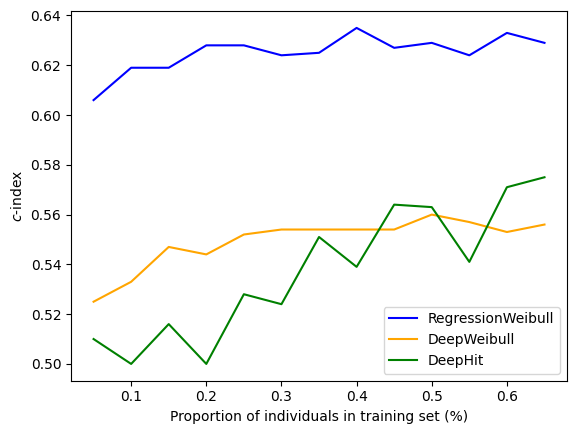

In [10]:

##results_df.to_csv("metabric_size_results.csv")



fig = plt.figure()
ax = plt.axes()

results_rw = results_df[results_df["model"]=="regression_weibull"]
results_dw = results_df[results_df["model"]=="deep_weibull"]
results_dh = results_df[results_df["model"]=="deep_hit"]

l1 = ax.plot(results_rw["train_frac"], results_rw["mean_c"], color="blue")[0]
l2 = ax.plot(results_dw["train_frac"], results_dw["mean_c"], color="orange")[0]
l3 = ax.plot(results_dh["train_frac"], results_dh["mean_c"], color="green")[0]

ax.legend([l1, l3, l3],     # The line objects
#ax.legend([l2],     # The line objects
           labels=["RegressionWeibull","DeepWeibull","DeepHit"]  # The labels for each line
          #labels=["DeepWeibull"] 
           )

plt.xlabel('Proportion of individuals in training set (%)')
plt.ylabel(r'$c$'+"-index")

#plot_file_path = "plots/real_data_experiments/metabric_training_size.pdf"
#plt.savefig(plot_file_path)